## Analyze solvent-accessible residues from PDB file
This notebook lets you calculate the solvent accesible charge properties of a alphafold generated SCO2 RBDs


In [1]:
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
	
# Set such that PDF fonts export in a manner that they
# are editable in illustrator/affinity
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# set to define axes linewidths
matplotlib.rcParams['axes.linewidth'] = 0.5

# this defines some prefactors so inline figures look nice
# on a retina macbook. These can be commented out without any
# issue and are solely asthetic.
%matplotlib inline
%config InlineBackend.figure_format='retina'

# UPDATE 2020-12-31 (my preferred font is Avenir...)
font = {'family' : 'arial',
    	'weight' : 'normal'}

matplotlib.rc('font', **font)

from sparrow import Protein
import metapredict as meta

In [2]:
from soursop.sstrajectory import SSTrajectory

In [3]:
prefix = './PDBs/'

In [4]:
# NB - this is an NMR ensemble with 40 conformers
N_protein = SSTrajectory(prefix + '1.pdb', prefix + '1.pdb').proteinTrajectoryList[0]

In [5]:
# from 44 to 180 in RBD
real_rbd_seq = 'ASWFTALTQHGKEDLKFPRGQGVPINTNSSPDDQIGYYRRATRRIRGGDGKMKDLSPRWYFYYLGTGPEAGLPYGANKDGIIWVATEGALNTPKDHIGTRNPANNAAIVLQLPQGTTLPKGFYA'

In [6]:
# figure out index where NTD actually starts
start_index = N_protein.get_amino_acid_sequence(oneletter=True).find(real_rbd_seq)

# sequence range identified from uniprot
all_resid = np.arange(51,175)

In [7]:
## Calculate SASA for each residue in frame and average. Note this works if you have a single-frame
## PDB file or a multi-frame NMR ensemble (or a trajectory for 1000s fo frames, but that would be VERY)
## slow and is not recomended... If you have a big trajectory set stride to a larger number!
# NOTE we have to set stride to 1 or we default to every 20 frames
sasa = N_protein.get_all_SASA(mode='residue', stride=1)
average_SASA = np.mean(sasa,0)

In [8]:
# get the SASA and the sequence after truncating cloning/expression scars from NTD
corrected_sasa = average_SASA[start_index:]
rbd_seq = N_protein.get_amino_acid_sequence(oneletter=True)[start_index:]


findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


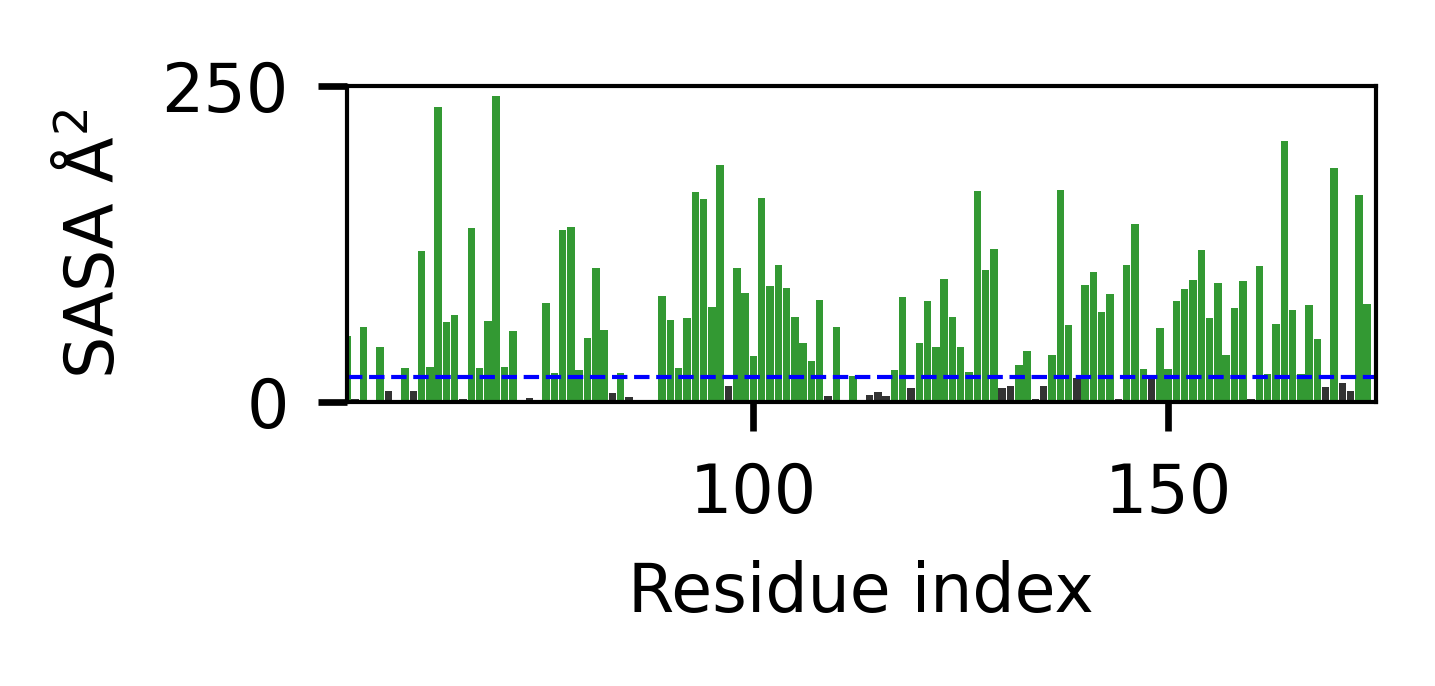

In [9]:
figure(num=None, figsize=(2.5, 1.2), dpi=300, facecolor='w', edgecolor='k')
ax = plt.gca()


color_below = 'black'
color_above = 'green'

# MAIN PARAMETER TO VARY - defines our threshold (in A^2) where we define something as solvent 
# accessible or not. Set to 20 based on the fact that this ensures glycine residues in the beta
# extension are accessible whereas the core of the RBD is not, but could also valry this to see
# if it matters. Could also calculated normalized SASA based on average SASA for each residue, but
# for now absolute SASA is probably sufficient for the gross properties we're interested in.
threshold = 20

accessible_residues =  [char for val, char in zip(corrected_sasa, rbd_seq) if val > threshold]



plt.axhline(y=threshold, color='blue', linestyle='--', linewidth=0.5)

color_list = np.where(corrected_sasa < threshold, color_below, color_above)
plt.bar(all_resid, average_SASA[start_index:], color=color_list, alpha=0.8, width=0.9)
plt.ylim([0,250])
plt.xlim([51,175])

plt.xticks(fontsize=8)
plt.xlabel('Residue index', fontsize=8)

plt.yticks(fontsize=8)
plt.ylabel(r'SASA Å$^2$', fontsize=8)
plt.tight_layout()
plt.savefig(prefix + 'SASA_exposed_residues.pdf')



### Write VMD data file
Write a VMD visualization file so we can visually check internal/external residues look OK

In [10]:
# now we're going to write out out VMD-compatible data file
with open(prefix +'SC2_1_SASA_binary_vmd.txt', 'w') as fh:

	# set the starting resid
    resid = 1
    chain = 'A'

    # cycle through each data point and write to a file where 
    # the format is 
    # <residue number> <chain> <value>
    for v in average_SASA:
        if v < threshold:
            fh.write('%i %s %2.4f\n' % (resid, chain, 0))
        else:
            fh.write('%i %s %2.4f\n' % (resid, chain, 1))
        resid = resid + 1


### Print proterities of solvent-accessible residues

In [11]:
RBD_sparrow = Protein("".join(accessible_residues))
print(f'Has {len(RBD_sparrow)} exposed residues')
print(f"FCR: {RBD_sparrow.FCR}")
print(f"NCPR: {RBD_sparrow.NCPR}")

with open(prefix +'CHARGE.txt', 'w') as fh:
    fh.write('Name, FCR, NCPR\n')
    fh.write(f"SCO2, {RBD_sparrow.FCR}, {RBD_sparrow.NCPR}")


Has 91 exposed residues
FCR: 0.2417582417582418
NCPR: 0.06593406593406594


## RBD Structure 1



Has 91 exposed residues
FCR: 0.2417582417582418
NCPR: 0.06593406593406594


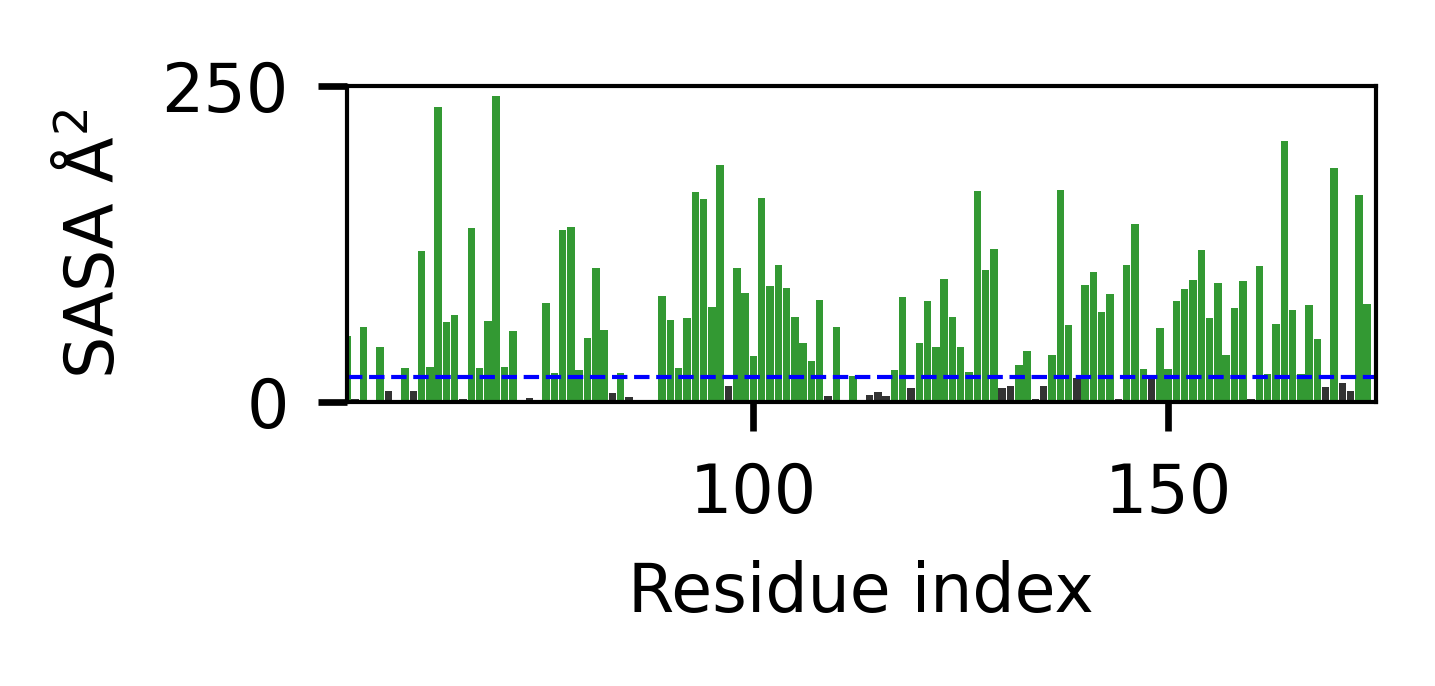

In [12]:
# NB - this is an NMR ensemble with 40 conformers
N_protein = SSTrajectory(prefix + '1.pdb', prefix + '1.pdb').proteinTrajectoryList[0]

# figure out index where NTD actually starts
start_index = N_protein.get_amino_acid_sequence(oneletter=True).find(real_rbd_seq)

# sequence range identified from uniprot
all_resid = np.arange(51,175)

## Calculate SASA for each residue in frame and average. Note this works if you have a single-frame
## PDB file or a multi-frame NMR ensemble (or a trajectory for 1000s fo frames, but that would be VERY)
## slow and is not recomended... If you have a big trajectory set stride to a larger number!
# NOTE we have to set stride to 1 or we default to every 20 frames
sasa = N_protein.get_all_SASA(mode='residue', stride=1)
average_SASA = np.mean(sasa,0)

# get the SASA and the sequence after truncating cloning/expression scars from NTD
corrected_sasa = average_SASA[start_index:]
rbd_seq = N_protein.get_amino_acid_sequence(oneletter=True)[start_index:]

figure(num=None, figsize=(2.5, 1.2), dpi=300, facecolor='w', edgecolor='k')
ax = plt.gca()


color_below = 'black'
color_above = 'green'

# MAIN PARAMETER TO VARY - defines our threshold (in A^2) where we define something as solvent 
# accessible or not. Set to 20 based on the fact that this ensures glycine residues in the beta
# extension are accessible whereas the core of the RBD is not, but could also valry this to see
# if it matters. Could also calculated normalized SASA based on average SASA for each residue, but
# for now absolute SASA is probably sufficient for the gross properties we're interested in.
threshold = 20

accessible_residues =  [char for val, char in zip(corrected_sasa, rbd_seq) if val > threshold]



plt.axhline(y=threshold, color='blue', linestyle='--', linewidth=0.5)

color_list = np.where(corrected_sasa < threshold, color_below, color_above)
plt.bar(all_resid, average_SASA[start_index:], color=color_list, alpha=0.8, width=0.9)
plt.ylim([0,250])
plt.xlim([51,175])

plt.xticks(fontsize=8)
plt.xlabel('Residue index', fontsize=8)

plt.yticks(fontsize=8)
plt.ylabel(r'SASA Å$^2$', fontsize=8)
plt.tight_layout()
plt.savefig(prefix + 'SASA_1_exposed_residues.pdf')

RBD_sparrow = Protein("".join(accessible_residues))
print(f'Has {len(RBD_sparrow)} exposed residues')
print(f"FCR: {RBD_sparrow.FCR}")
print(f"NCPR: {RBD_sparrow.NCPR}")

with open(prefix +'CHARGE_1.txt', 'w') as fh:
    fh.write('Name, FCR, NCPR\n')
    fh.write(f"SCO2, {RBD_sparrow.FCR}, {RBD_sparrow.NCPR}")


## RBD Structure 2



Has 90 exposed residues
FCR: 0.24444444444444446
NCPR: 0.06666666666666667


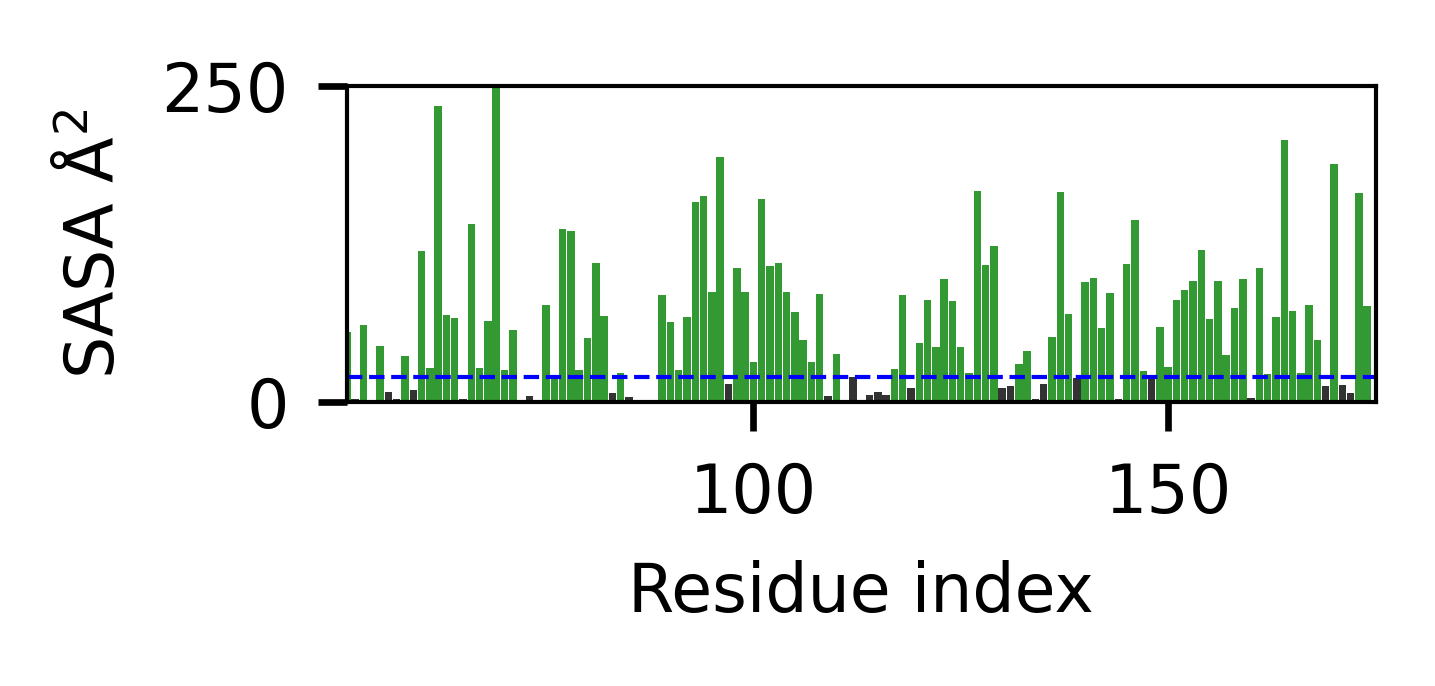

In [13]:
# NB - this is an NMR ensemble with 40 conformers
N_protein = SSTrajectory(prefix + '2.pdb', prefix + '2.pdb').proteinTrajectoryList[0]

# figure out index where NTD actually starts
start_index = N_protein.get_amino_acid_sequence(oneletter=True).find(real_rbd_seq)

# sequence range identified from uniprot
all_resid = np.arange(51,175)

## Calculate SASA for each residue in frame and average. Note this works if you have a single-frame
## PDB file or a multi-frame NMR ensemble (or a trajectory for 1000s fo frames, but that would be VERY)
## slow and is not recomended... If you have a big trajectory set stride to a larger number!
# NOTE we have to set stride to 1 or we default to every 20 frames
sasa = N_protein.get_all_SASA(mode='residue', stride=1)
average_SASA = np.mean(sasa,0)

# get the SASA and the sequence after truncating cloning/expression scars from NTD
corrected_sasa = average_SASA[start_index:]
rbd_seq = N_protein.get_amino_acid_sequence(oneletter=True)[start_index:]

figure(num=None, figsize=(2.5, 1.2), dpi=300, facecolor='w', edgecolor='k')
ax = plt.gca()


color_below = 'black'
color_above = 'green'

# MAIN PARAMETER TO VARY - defines our threshold (in A^2) where we define something as solvent 
# accessible or not. Set to 20 based on the fact that this ensures glycine residues in the beta
# extension are accessible whereas the core of the RBD is not, but could also valry this to see
# if it matters. Could also calculated normalized SASA based on average SASA for each residue, but
# for now absolute SASA is probably sufficient for the gross properties we're interested in.
threshold = 20

accessible_residues =  [char for val, char in zip(corrected_sasa, rbd_seq) if val > threshold]



plt.axhline(y=threshold, color='blue', linestyle='--', linewidth=0.5)

color_list = np.where(corrected_sasa < threshold, color_below, color_above)
plt.bar(all_resid, average_SASA[start_index:], color=color_list, alpha=0.8, width=0.9)
plt.ylim([0,250])
plt.xlim([51,175])

plt.xticks(fontsize=8)
plt.xlabel('Residue index', fontsize=8)

plt.yticks(fontsize=8)
plt.ylabel(r'SASA Å$^2$', fontsize=8)
plt.tight_layout()
plt.savefig(prefix + 'SASA_1_exposed_residues.pdf')

RBD_sparrow = Protein("".join(accessible_residues))
print(f'Has {len(RBD_sparrow)} exposed residues')
print(f"FCR: {RBD_sparrow.FCR}")
print(f"NCPR: {RBD_sparrow.NCPR}")

with open(prefix +'CHARGE_1.txt', 'w') as fh:
    fh.write('Name, FCR, NCPR\n')
    fh.write(f"SCO2, {RBD_sparrow.FCR}, {RBD_sparrow.NCPR}")

## RBD Structure 3



Has 91 exposed residues
FCR: 0.2417582417582418
NCPR: 0.06593406593406594


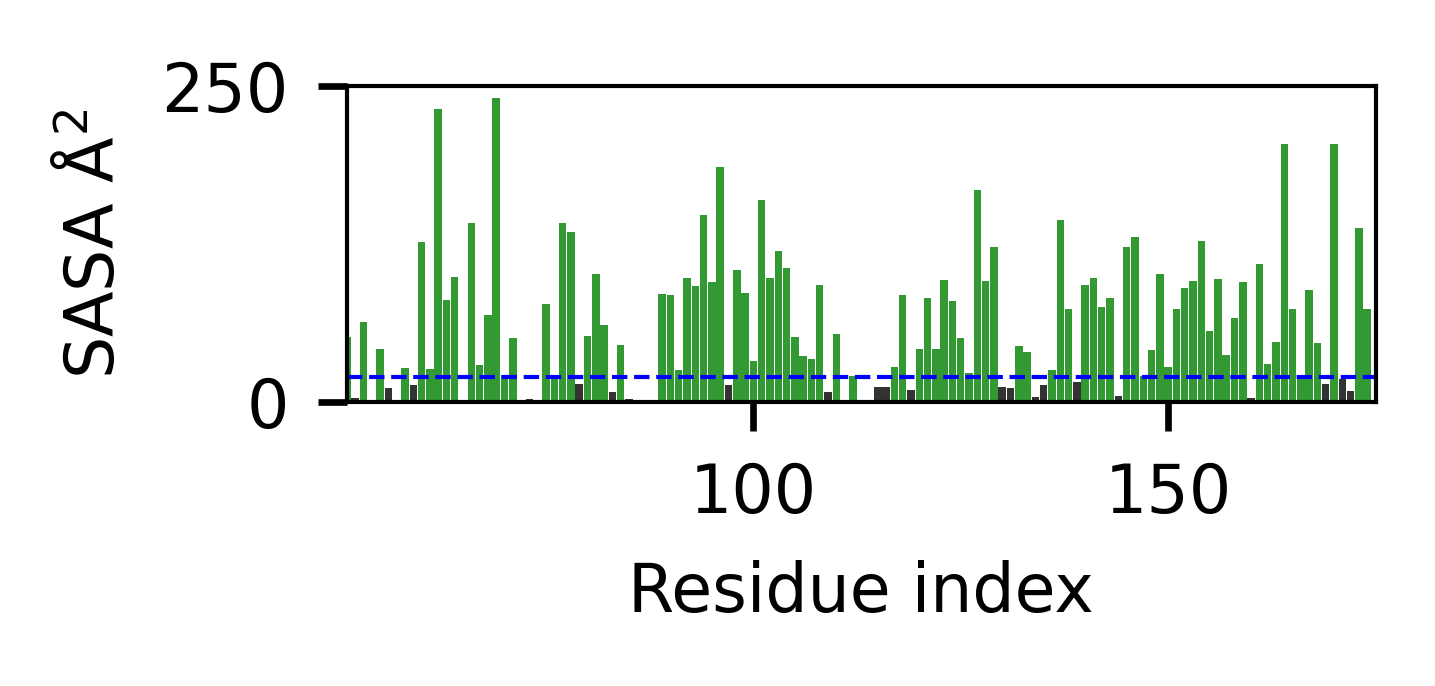

In [14]:
# NB - this is an NMR ensemble with 40 conformers
N_protein = SSTrajectory(prefix + '3.pdb', prefix + '3.pdb').proteinTrajectoryList[0]

# figure out index where NTD actually starts
start_index = N_protein.get_amino_acid_sequence(oneletter=True).find(real_rbd_seq)

# sequence range identified from uniprot
all_resid = np.arange(51,175)

## Calculate SASA for each residue in frame and average. Note this works if you have a single-frame
## PDB file or a multi-frame NMR ensemble (or a trajectory for 1000s fo frames, but that would be VERY)
## slow and is not recomended... If you have a big trajectory set stride to a larger number!
# NOTE we have to set stride to 1 or we default to every 20 frames
sasa = N_protein.get_all_SASA(mode='residue', stride=1)
average_SASA = np.mean(sasa,0)

# get the SASA and the sequence after truncating cloning/expression scars from NTD
corrected_sasa = average_SASA[start_index:]
rbd_seq = N_protein.get_amino_acid_sequence(oneletter=True)[start_index:]

figure(num=None, figsize=(2.5, 1.2), dpi=300, facecolor='w', edgecolor='k')
ax = plt.gca()


color_below = 'black'
color_above = 'green'

# MAIN PARAMETER TO VARY - defines our threshold (in A^2) where we define something as solvent 
# accessible or not. Set to 20 based on the fact that this ensures glycine residues in the beta
# extension are accessible whereas the core of the RBD is not, but could also valry this to see
# if it matters. Could also calculated normalized SASA based on average SASA for each residue, but
# for now absolute SASA is probably sufficient for the gross properties we're interested in.
threshold = 20

accessible_residues =  [char for val, char in zip(corrected_sasa, rbd_seq) if val > threshold]



plt.axhline(y=threshold, color='blue', linestyle='--', linewidth=0.5)

color_list = np.where(corrected_sasa < threshold, color_below, color_above)
plt.bar(all_resid, average_SASA[start_index:], color=color_list, alpha=0.8, width=0.9)
plt.ylim([0,250])
plt.xlim([51,175])

plt.xticks(fontsize=8)
plt.xlabel('Residue index', fontsize=8)

plt.yticks(fontsize=8)
plt.ylabel(r'SASA Å$^2$', fontsize=8)
plt.tight_layout()
plt.savefig(prefix + 'SASA_3_exposed_residues.pdf')

RBD_sparrow = Protein("".join(accessible_residues))
print(f'Has {len(RBD_sparrow)} exposed residues')
print(f"FCR: {RBD_sparrow.FCR}")
print(f"NCPR: {RBD_sparrow.NCPR}")

with open(prefix +'CHARGE_3.txt', 'w') as fh:
    fh.write('Name, FCR, NCPR\n')
    fh.write(f"SCO2, {RBD_sparrow.FCR}, {RBD_sparrow.NCPR}")

## RBD Structure 4



Has 88 exposed residues
FCR: 0.25
NCPR: 0.06818181818181818


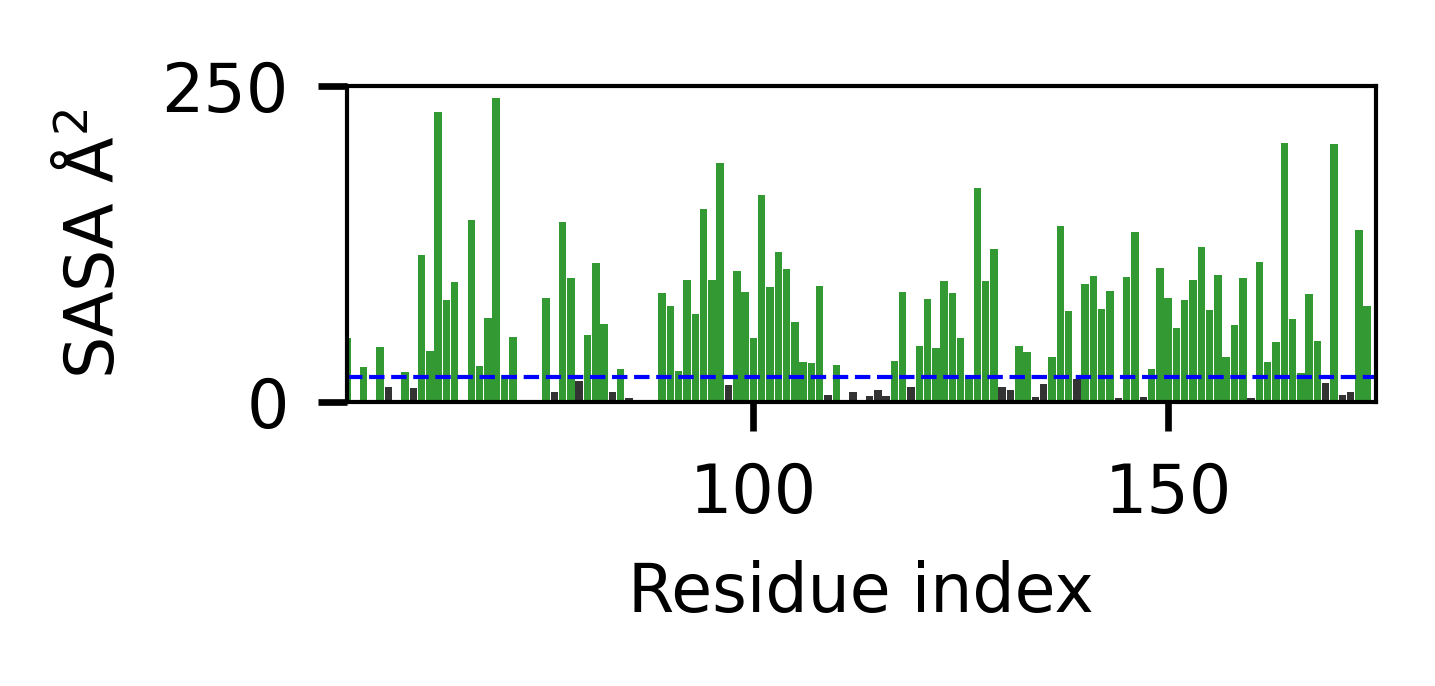

In [15]:
# NB - this is an NMR ensemble with 40 conformers
N_protein = SSTrajectory(prefix + '4.pdb', prefix + '4.pdb').proteinTrajectoryList[0]

# figure out index where NTD actually starts
start_index = N_protein.get_amino_acid_sequence(oneletter=True).find(real_rbd_seq)

# sequence range identified from uniprot
all_resid = np.arange(51,175)

## Calculate SASA for each residue in frame and average. Note this works if you have a single-frame
## PDB file or a multi-frame NMR ensemble (or a trajectory for 1000s fo frames, but that would be VERY)
## slow and is not recomended... If you have a big trajectory set stride to a larger number!
# NOTE we have to set stride to 1 or we default to every 20 frames
sasa = N_protein.get_all_SASA(mode='residue', stride=1)
average_SASA = np.mean(sasa,0)

# get the SASA and the sequence after truncating cloning/expression scars from NTD
corrected_sasa = average_SASA[start_index:]
rbd_seq = N_protein.get_amino_acid_sequence(oneletter=True)[start_index:]

figure(num=None, figsize=(2.5, 1.2), dpi=300, facecolor='w', edgecolor='k')
ax = plt.gca()


color_below = 'black'
color_above = 'green'

# MAIN PARAMETER TO VARY - defines our threshold (in A^2) where we define something as solvent 
# accessible or not. Set to 20 based on the fact that this ensures glycine residues in the beta
# extension are accessible whereas the core of the RBD is not, but could also valry this to see
# if it matters. Could also calculated normalized SASA based on average SASA for each residue, but
# for now absolute SASA is probably sufficient for the gross properties we're interested in.
threshold = 20

accessible_residues =  [char for val, char in zip(corrected_sasa, rbd_seq) if val > threshold]



plt.axhline(y=threshold, color='blue', linestyle='--', linewidth=0.5)

color_list = np.where(corrected_sasa < threshold, color_below, color_above)
plt.bar(all_resid, average_SASA[start_index:], color=color_list, alpha=0.8, width=0.9)
plt.ylim([0,250])
plt.xlim([51,175])

plt.xticks(fontsize=8)
plt.xlabel('Residue index', fontsize=8)

plt.yticks(fontsize=8)
plt.ylabel(r'SASA Å$^2$', fontsize=8)
plt.tight_layout()
plt.savefig(prefix + 'SASA_4_exposed_residues.pdf')

RBD_sparrow = Protein("".join(accessible_residues))
print(f'Has {len(RBD_sparrow)} exposed residues')
print(f"FCR: {RBD_sparrow.FCR}")
print(f"NCPR: {RBD_sparrow.NCPR}")

with open(prefix +'CHARGE_4.txt', 'w') as fh:
    fh.write('Name, FCR, NCPR\n')
    fh.write(f"SCO2, {RBD_sparrow.FCR}, {RBD_sparrow.NCPR}")

## RBD Structure 5



Has 91 exposed residues
FCR: 0.2417582417582418
NCPR: 0.06593406593406594


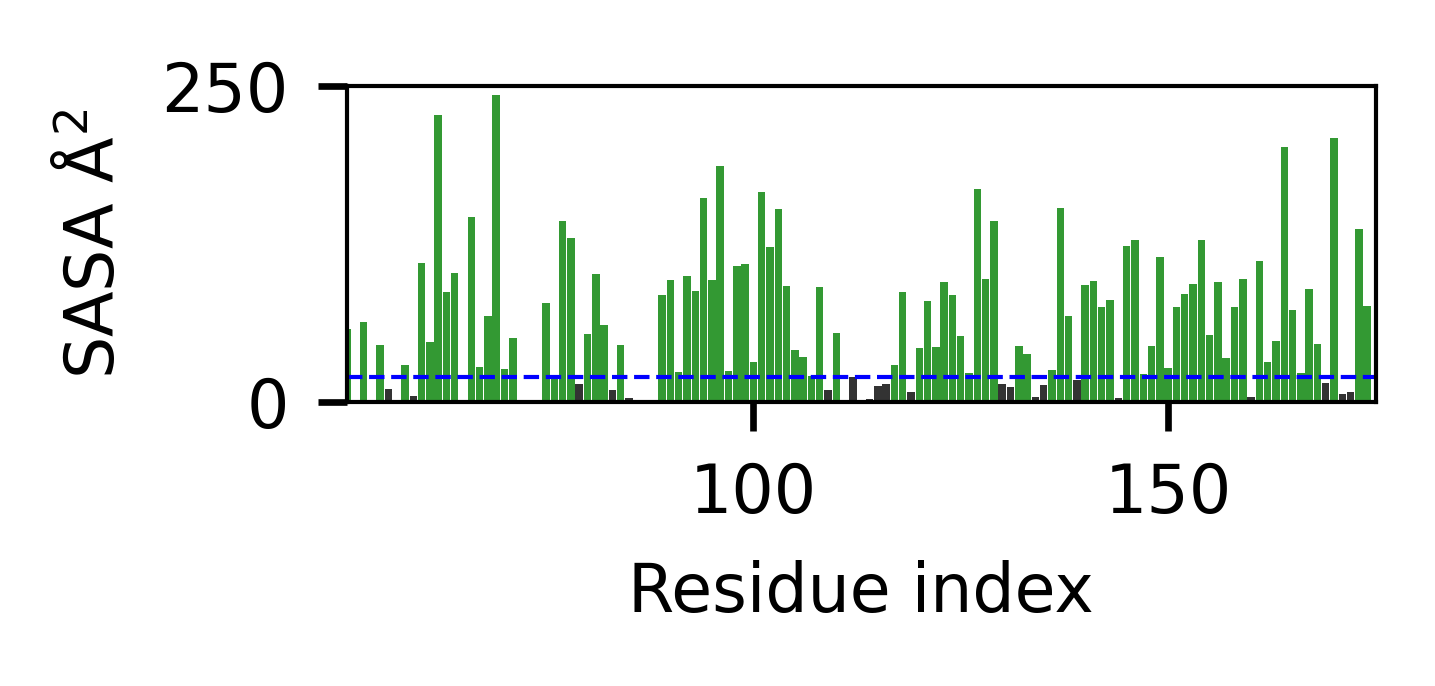

In [16]:
# NB - this is an NMR ensemble with 40 conformers
N_protein = SSTrajectory(prefix + '5.pdb', prefix + '5.pdb').proteinTrajectoryList[0]

# figure out index where NTD actually starts
start_index = N_protein.get_amino_acid_sequence(oneletter=True).find(real_rbd_seq)

# sequence range identified from uniprot
all_resid = np.arange(51,175)

## Calculate SASA for each residue in frame and average. Note this works if you have a single-frame
## PDB file or a multi-frame NMR ensemble (or a trajectory for 1000s fo frames, but that would be VERY)
## slow and is not recomended... If you have a big trajectory set stride to a larger number!
# NOTE we have to set stride to 1 or we default to every 20 frames
sasa = N_protein.get_all_SASA(mode='residue', stride=1)
average_SASA = np.mean(sasa,0)

# get the SASA and the sequence after truncating cloning/expression scars from NTD
corrected_sasa = average_SASA[start_index:]
rbd_seq = N_protein.get_amino_acid_sequence(oneletter=True)[start_index:]

figure(num=None, figsize=(2.5, 1.2), dpi=300, facecolor='w', edgecolor='k')
ax = plt.gca()


color_below = 'black'
color_above = 'green'

# MAIN PARAMETER TO VARY - defines our threshold (in A^2) where we define something as solvent 
# accessible or not. Set to 20 based on the fact that this ensures glycine residues in the beta
# extension are accessible whereas the core of the RBD is not, but could also valry this to see
# if it matters. Could also calculated normalized SASA based on average SASA for each residue, but
# for now absolute SASA is probably sufficient for the gross properties we're interested in.
threshold = 20

accessible_residues =  [char for val, char in zip(corrected_sasa, rbd_seq) if val > threshold]



plt.axhline(y=threshold, color='blue', linestyle='--', linewidth=0.5)

color_list = np.where(corrected_sasa < threshold, color_below, color_above)
plt.bar(all_resid, average_SASA[start_index:], color=color_list, alpha=0.8, width=0.9)
plt.ylim([0,250])
plt.xlim([51,175])

plt.xticks(fontsize=8)
plt.xlabel('Residue index', fontsize=8)

plt.yticks(fontsize=8)
plt.ylabel(r'SASA Å$^2$', fontsize=8)
plt.tight_layout()
plt.savefig(prefix + 'SASA_5_exposed_residues.pdf')

RBD_sparrow = Protein("".join(accessible_residues))
print(f'Has {len(RBD_sparrow)} exposed residues')
print(f"FCR: {RBD_sparrow.FCR}")
print(f"NCPR: {RBD_sparrow.NCPR}")

with open(prefix +'CHARGE_5.txt', 'w') as fh:
    fh.write('Name, FCR, NCPR\n')
    fh.write(f"SCO2, {RBD_sparrow.FCR}, {RBD_sparrow.NCPR}")